## Macro Factor Timing via Regime Shifts — Phase 1


In [68]:
# === Macro Factor Timing via Regime Shifts — Phase 1 ===
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import os

sns.set(style="whitegrid")

# 📅 Date Range
start_date = "2005-01-01"
end_date = "2024-12-31"

# 📈 Download SPY, TLT, SHY — Monthly Prices
etfs = ['SPY', 'TLT', 'SHY']
prices_raw = yf.download(etfs, start=start_date, end=end_date, interval="1mo")

/var/folders/8f/8x77b8nd28388ydp8lljv7c80000gn/T/ipykernel_34867/987612597.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices_raw = yf.download(etfs, start=start_date, end=end_date, interval="1mo")
[*********************100%***********************]  3 of 3 completed


In [69]:
# Handle 'Adj Close' or fallback to 'Close'

if isinstance(prices_raw.columns, pd.MultiIndex):
    if 'Adj Close' in prices_raw.columns.levels[0]:
        prices = prices_raw['Adj Close']
    elif 'Close' in prices_raw.columns.levels[0]:
        prices = prices_raw['Close']
    else:
        raise KeyError("Neither 'Adj Close' nor 'Close' found in multi-index columns.")
else:
    if 'Adj Close' in prices_raw.columns:
        prices = prices_raw['Adj Close']
    elif 'Close' in prices_raw.columns:
        prices = prices_raw['Close']
    else:
        raise KeyError("Neither 'Adj Close' nor 'Close' found in flat columns.")

# 🧮 ETF returns
prices = prices.dropna()
returns = prices.pct_change().dropna()

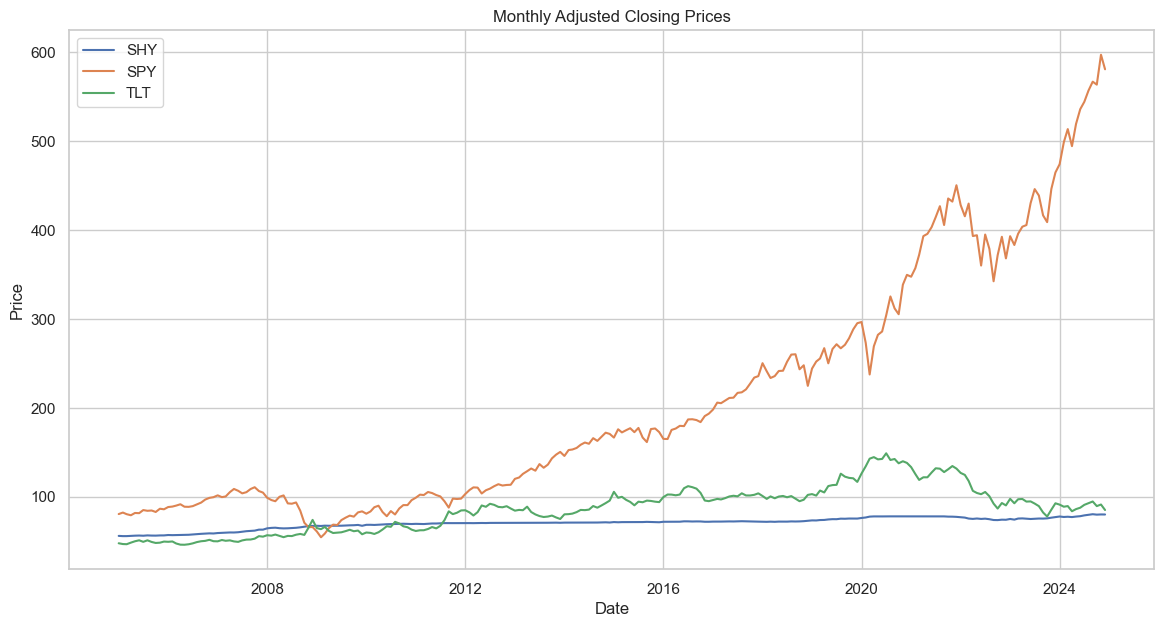

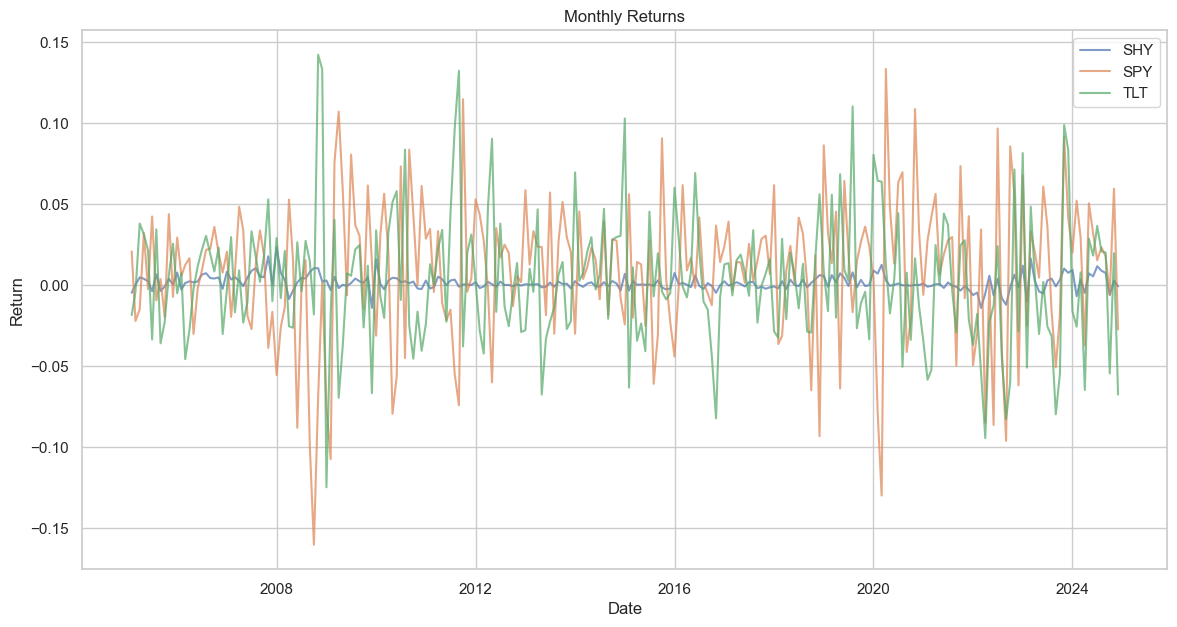

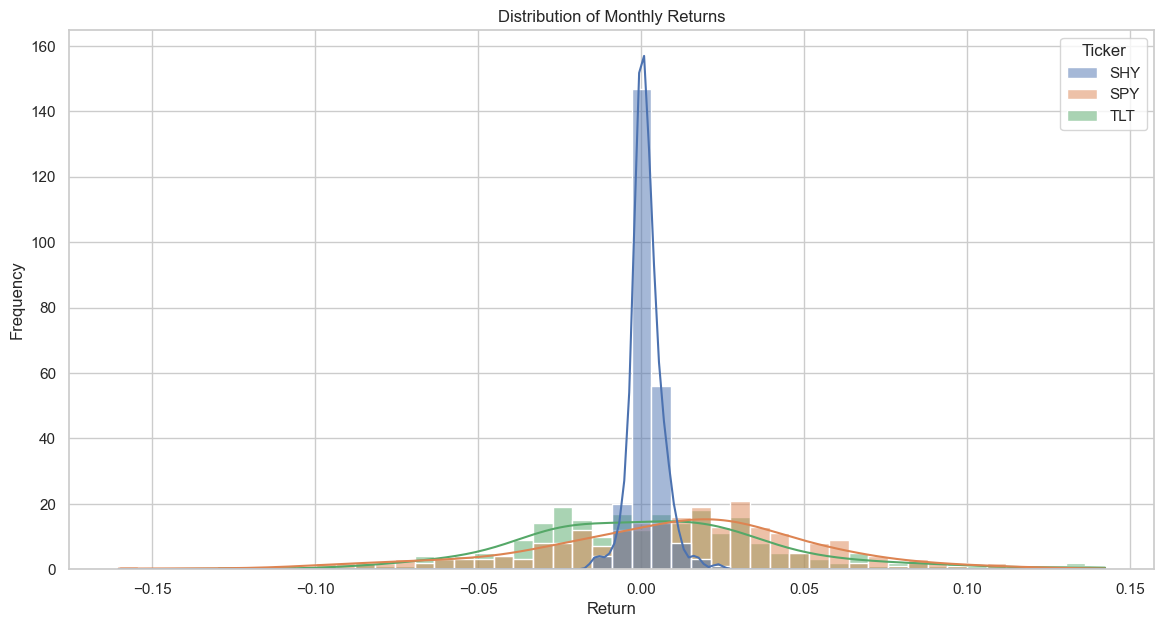

In [70]:
# prompt: visualize the data above.

import matplotlib.pyplot as plt
# Use 'Adj Close' if available, otherwise use 'Close'
if 'Adj Close' in prices_raw.columns:
  prices = prices_raw['Adj Close'].dropna()
else:
  prices = prices_raw['Close'].dropna()

# Resample to monthly to ensure consistency after potential missing values handling
# Although yfinance with interval="1mo" should ideally handle this,
# explicit monthly resampling can sometimes catch edge cases depending on data availability.
# We'll keep the original prices dataframe as it's already monthly
# prices = prices.resample('M').ffill().dropna() # This line is not strictly necessary if interval="1mo" works as expected

# Visualize the monthly adjusted closing prices
plt.figure(figsize=(14, 7))
for col in prices.columns:
  plt.plot(prices.index, prices[col], label=col)

plt.title('Monthly Adjusted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and visualize monthly returns
returns = prices.pct_change().dropna()

plt.figure(figsize=(14, 7))
for col in returns.columns:
  plt.plot(returns.index, returns[col], label=col, alpha=0.7)

plt.title('Monthly Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

# Visualize the distribution of returns
plt.figure(figsize=(14, 7))
sns.histplot(data=returns, bins=50, kde=True)
plt.title('Distribution of Monthly Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()

## Downloading the macro-economic files from FRED.

In [71]:
macro_files = {
    'CPI': '/Users/parthasarathichakraborty/Downloads/project/macro_factor_timing/data/Consumer_Price_Index.csv',
    'FedFunds': '/Users/parthasarathichakraborty/Downloads/project/macro_factor_timing/data/FEDFUNDS.csv',
    'Employment': '/Users/parthasarathichakraborty/Downloads/project/macro_factor_timing/data/Total_Nonfarm_(PAYEMS).csv',
    'PPI': '/Users/parthasarathichakraborty/Downloads/project/macro_factor_timing/data/Producer_Price_Index.csv',
    'YieldSpread': '/Users/parthasarathichakraborty/Downloads/project/macro_factor_timing/data/T10Y2Y_YieldSpread.csv'     
}

macro_data = pd.DataFrame()

for label, file in macro_files.items():
    if not os.path.exists(file):
        print(f"Warning: File not found for {label}: {file}. Skipping.")
        continue
    df = pd.read_csv(file, skiprows=1)  # Skip FRED headers
    df.columns = ['Date', label]
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    macro_data = pd.concat([macro_data, df], axis=1)

# 🧹 Monthly resample, forward fill, trim to range
macro_data = macro_data[start_date:end_date].resample('M').last()
macro_data = macro_data.ffill().dropna()

# 🧮 Transformations
macro_data['PPI_YoY'] = macro_data['PPI'].pct_change(periods=12) * 100
macro_data['Employment_YoY'] = macro_data['Employment'].pct_change(periods=12) * 100

# Drop raw columns to avoid redundancy
macro_data.drop(columns=['PPI', 'Employment'], inplace=True)

/var/folders/8f/8x77b8nd28388ydp8lljv7c80000gn/T/ipykernel_34867/1627645573.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  macro_data = macro_data[start_date:end_date].resample('M').last()


In [72]:
# ✅ Final feature selection
desired_features = ['CPI', 'PPI_YoY', 'FedFunds', 'Employment_YoY', 'YieldSpread']
existing_features = [col for col in desired_features if col in macro_data.columns]
if len(existing_features) < len(desired_features):
    missing = set(desired_features) - set(existing_features)
    print(f"Warning: Missing features in macro_data: {missing}")
macro_data = macro_data[existing_features]

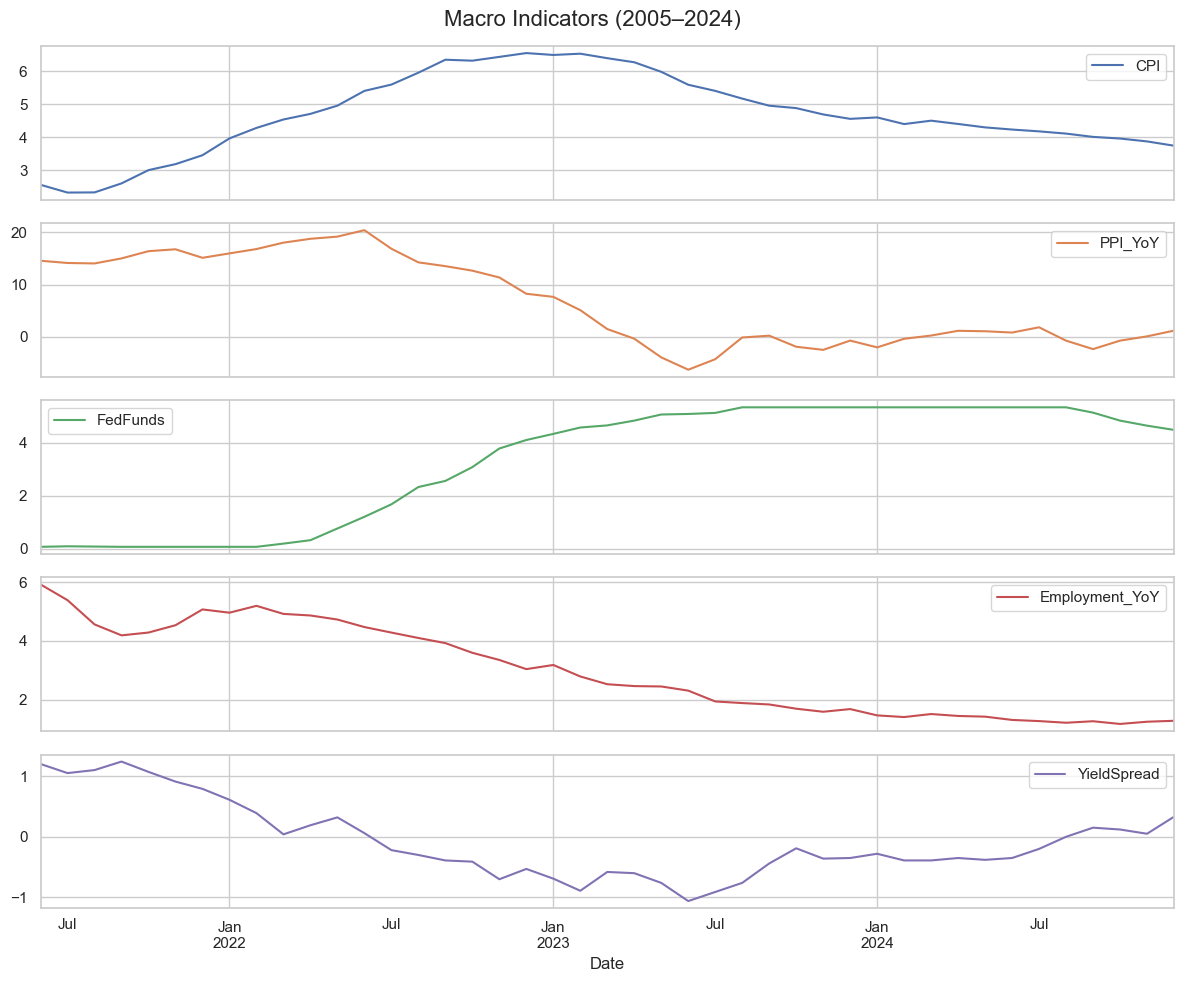

In [73]:
# 🔄 Align both indexes to month-end to fix merge issues
macro_data.index = macro_data.index.to_period('M').to_timestamp('M')
returns.index = returns.index.to_period('M').to_timestamp('M')

# 🔁 Merge Macro Data with ETF Monthly Returns
combined = pd.merge(macro_data, returns, left_index=True, right_index=True)
combined.columns = list(macro_data.columns) + ['SPY_ret', 'TLT_ret', 'SHY_ret']
combined.dropna(inplace=True)

# 📊 Quick EDA: Macro Indicators
macro_cols_to_plot = [col for col in desired_features if col in combined.columns]
if macro_cols_to_plot:
    combined[macro_cols_to_plot].plot(subplots=True, figsize=(12, 10), title="Macro Indicators (2005–2024)")
    plt.suptitle("Macro Indicators (2005–2024)", fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("No macro columns available for plotting.")

In [74]:
# ✅ Output: Combined DataFrame ready for modeling
print("\n✅ Final Combined Dataset Preview:")
print(combined.info())
combined.head()


✅ Final Combined Dataset Preview:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43 entries, 2021-06-30 to 2024-12-31
Freq: ME
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CPI             43 non-null     float64
 1   PPI_YoY         43 non-null     float64
 2   FedFunds        43 non-null     float64
 3   Employment_YoY  43 non-null     float64
 4   YieldSpread     43 non-null     float64
 5   SPY_ret         43 non-null     float64
 6   TLT_ret         43 non-null     float64
 7   SHY_ret         43 non-null     float64
dtypes: float64(8)
memory usage: 3.0 KB
None


,CPI,PPI_YoY,FedFunds,Employment_YoY,YieldSpread,SPY_ret,TLT_ret,SHY_ret
Date,,,,,,,,
2021-06-30,2.564809,14.563617,0.08,5.924995,1.20,-0.001715,0.019093,0.044220
2021-07-31,2.330438,14.140406,0.10,5.388675,1.05,0.001648,0.027764,0.037306
2021-08-31,2.335721,14.048705,0.09,4.564015,1.10,-0.000313,0.029760,-0.003317
2021-09-30,2.607496,15.017626,0.08,4.191296,1.24,-0.001021,-0.049650,-0.029121
2021-10-31,3.009235,16.405782,0.08,4.287489,1.07,-0.003332,0.073592,0.024652


## Phase 2: Regime Detection via KMeans

Objective - Cluster months into distinct macro regimes using macro indicators (CPI, PPI_YoY, FedFunds, Employment_YoY, YieldSpread) using KMeans.

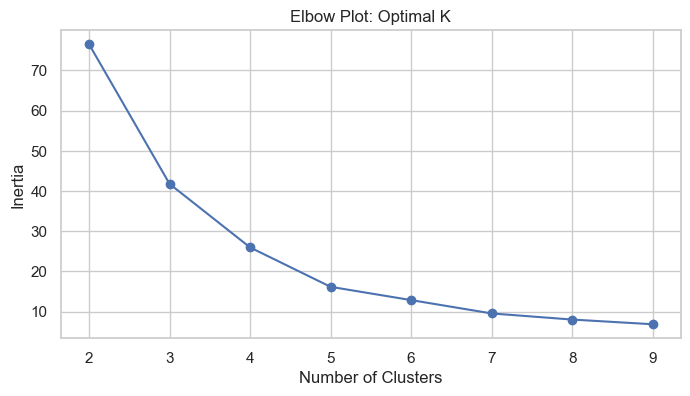

In [75]:
# === Phase 2: Regime Detection via KMeans Clustering ===
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 🎯 Features to Cluster On (already selected in Phase 1)
X = combined[['CPI', 'PPI_YoY', 'FedFunds', 'Employment_YoY', 'YieldSpread']]

# 🔄 Standardize the Macro Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔍 Elbow Method to Pick Number of Clusters
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Plot: Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

                 CPI    PPI_YoY  FedFunds  Employment_YoY  YieldSpread  Regime
Date                                                                          
2021-06-30  2.564809  14.563617      0.08        5.924995         1.20       2
2021-07-31  2.330438  14.140406      0.10        5.388675         1.05       2
2021-08-31  2.335721  14.048705      0.09        4.564015         1.10       2
2021-09-30  2.607496  15.017626      0.08        4.191296         1.24       2
2021-10-31  3.009235  16.405782      0.08        4.287489         1.07       2


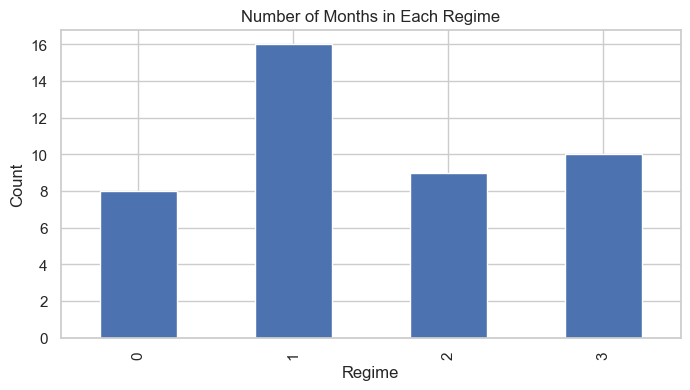

In [76]:
# FINAL KMeans with chosen k
chosen_k = 4  # or 5 if you prefer
kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
combined['Regime'] = kmeans_final.fit_predict(X_scaled)

# View sample output
print(combined[['CPI', 'PPI_YoY', 'FedFunds', 'Employment_YoY', 'YieldSpread', 'Regime']].head())

# Visualize regime distribution
plt.figure(figsize=(8, 4))
combined['Regime'].value_counts().sort_index().plot(kind='bar')
plt.title("Number of Months in Each Regime")
plt.xlabel("Regime")
plt.ylabel("Count")
plt.show()

Macro indicator means by regime:
             CPI    PPI_YoY  FedFunds  Employment_YoY  YieldSpread
Regime                                                            
0       5.476530  16.721636  1.520000        4.363369    -0.088750
1       4.338775  -0.327241  5.190000        1.426799    -0.189375
2       3.083018  15.429754  0.083333        4.902974     0.928889
3       6.078937   1.858379  4.685000        2.594478    -0.748000


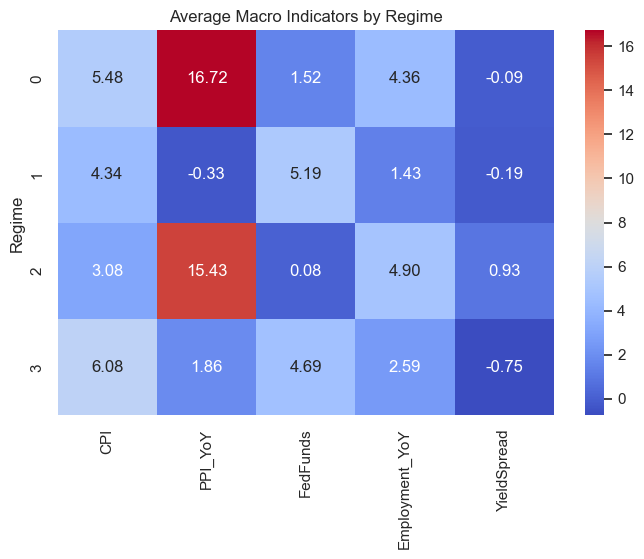

Average asset returns by regime (%):
         SPY_ret   TLT_ret   SHY_ret
Regime                              
0      -0.465091 -1.114329 -4.351516
1       0.366959  1.835643 -0.177511
2      -0.208773  0.624208  0.285357
3       0.239349  1.750611  0.403770


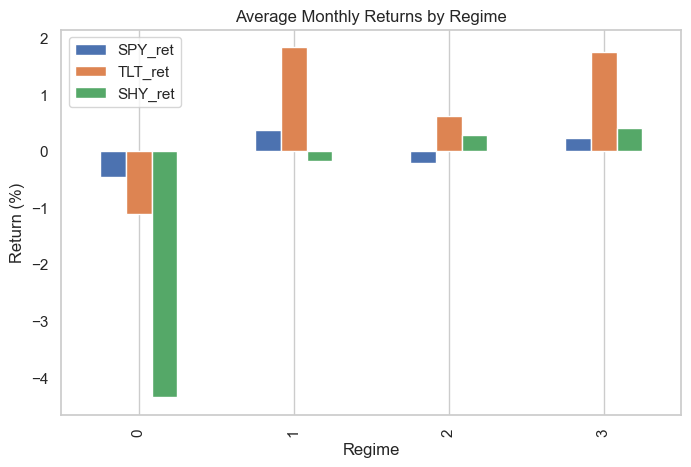

In [77]:
# 1️⃣ Macro profile of each regime
macro_means = combined.groupby('Regime')[['CPI', 'PPI_YoY', 'FedFunds', 'Employment_YoY', 'YieldSpread']].mean()
print("Macro indicator means by regime:")
print(macro_means)

# Heatmap for visualization
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.heatmap(macro_means, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Average Macro Indicators by Regime")
plt.show()

# 2️⃣ Asset return behavior by regime
returns_means = combined.groupby('Regime')[['SPY_ret', 'TLT_ret', 'SHY_ret']].mean() * 100
print("Average asset returns by regime (%):")
print(returns_means)

# Bar plot for returns
returns_means.plot(kind='bar', figsize=(8, 5))
plt.title("Average Monthly Returns by Regime")
plt.ylabel("Return (%)")
plt.grid(axis='y')
plt.show()

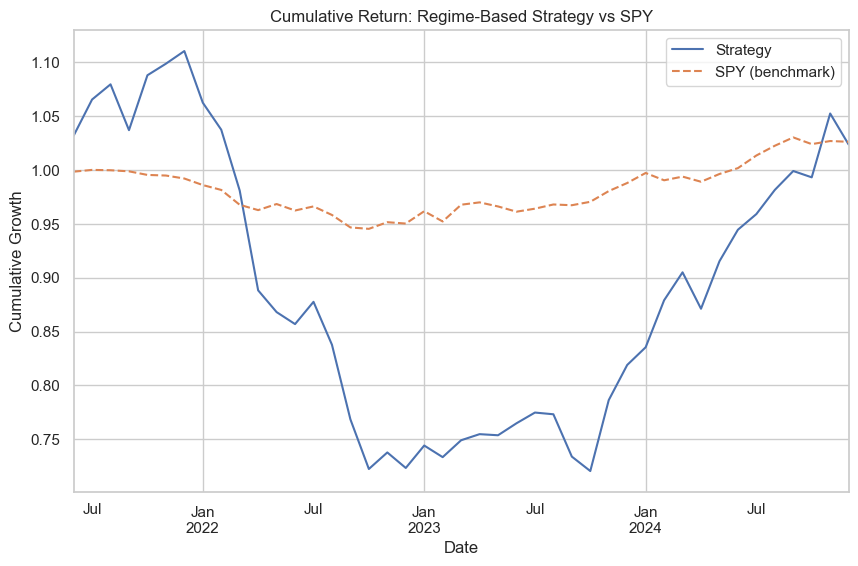

In [78]:
# === Simulate regime-based portfolio ===

# Define weights by regime
regime_weights = {
    0: {'SPY_ret': 0.0, 'TLT_ret': 0.0, 'SHY_ret': 1.0},
    1: {'SPY_ret': 0.0, 'TLT_ret': 1.0, 'SHY_ret': 0.0},
    2: {'SPY_ret': 0.0, 'TLT_ret': 0.5, 'SHY_ret': 0.5},
    3: {'SPY_ret': 0.7, 'TLT_ret': 0.3, 'SHY_ret': 0.0}
}

# Apply weights row by row
def apply_weights(row):
    w = regime_weights[row['Regime']]
    return (row['SPY_ret'] * w['SPY_ret'] +
            row['TLT_ret'] * w['TLT_ret'] +
            row['SHY_ret'] * w['SHY_ret'])

combined['Strategy_ret'] = combined.apply(apply_weights, axis=1)

# Compute cumulative return
combined['Cumulative'] = (1 + combined['Strategy_ret']).cumprod()

# Plot cumulative return
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
combined['Cumulative'].plot(label='Strategy')
(1 + combined['SPY_ret']).cumprod().plot(label='SPY (benchmark)', linestyle='--')
plt.title("Cumulative Return: Regime-Based Strategy vs SPY")
plt.ylabel("Cumulative Growth")
plt.legend()
plt.grid(True)
plt.show()

In [79]:
import numpy as np

def compute_cagr(series):
    n_years = (series.index[-1] - series.index[0]).days / 365.25
    return (series[-1] / series[0])**(1 / n_years) - 1

def compute_max_drawdown(series):
    cum_max = series.cummax()
    drawdown = (series / cum_max) - 1
    return drawdown.min()

def compute_sharpe(series):
    # Assume monthly returns, annualize
    mean = combined['Strategy_ret'].mean()
    std = combined['Strategy_ret'].std()
    sharpe = (mean / std) * np.sqrt(12)
    return sharpe

cagr = compute_cagr(combined['Cumulative'])
mdd = compute_max_drawdown(combined['Cumulative'])
sharpe = compute_sharpe(combined['Strategy_ret'])

print(f"CAGR: {cagr:.2%}")
print(f"Max Drawdown: {mdd:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")

CAGR: -0.23%
Max Drawdown: -35.09%
Sharpe Ratio: 0.11


/var/folders/8f/8x77b8nd28388ydp8lljv7c80000gn/T/ipykernel_34867/120090985.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0])**(1 / n_years) - 1


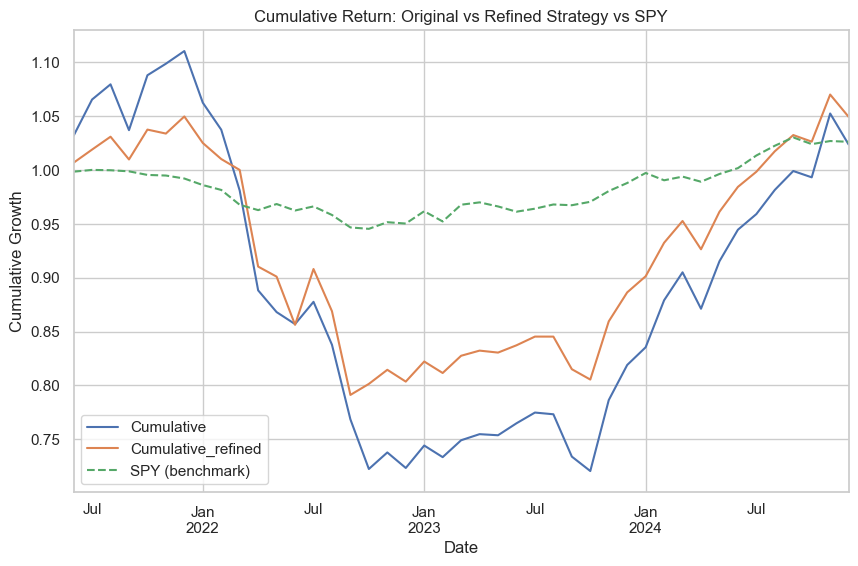

In [80]:
refined_weights = {
    0: {'SPY_ret': 0.0, 'TLT_ret': 0.5, 'SHY_ret': 0.5},
    1: {'SPY_ret': 0.3, 'TLT_ret': 0.7, 'SHY_ret': 0.0},
    2: {'SPY_ret': 0.6, 'TLT_ret': 0.4, 'SHY_ret': 0.0},
    3: {'SPY_ret': 0.8, 'TLT_ret': 0.2, 'SHY_ret': 0.0}
}

combined['Strategy_ret_refined'] = combined.apply(
    lambda row: (
        row['SPY_ret'] * refined_weights[row['Regime']]['SPY_ret'] +
        row['TLT_ret'] * refined_weights[row['Regime']]['TLT_ret'] +
        row['SHY_ret'] * refined_weights[row['Regime']]['SHY_ret']
    ), axis=1
)

combined['Cumulative_refined'] = (1 + combined['Strategy_ret_refined']).cumprod()

# Plot
combined[['Cumulative', 'Cumulative_refined']].plot(figsize=(10,6))
(1 + combined['SPY_ret']).cumprod().plot(style='--', label='SPY (benchmark)')
plt.title("Cumulative Return: Original vs Refined Strategy vs SPY")
plt.ylabel("Cumulative Growth")
plt.legend()
plt.grid(True)
plt.show()

In [81]:
# Reuse metrics functions but for refined strategy
cagr_refined = compute_cagr(combined['Cumulative_refined'])
mdd_refined = compute_max_drawdown(combined['Cumulative_refined'])
sharpe_refined = (combined['Strategy_ret_refined'].mean() / combined['Strategy_ret_refined'].std()) * np.sqrt(12)

print(f"Refined Strategy - CAGR: {cagr_refined:.2%}")
print(f"Refined Strategy - Max Drawdown: {mdd_refined:.2%}")
print(f"Refined Strategy - Sharpe Ratio: {sharpe_refined:.2f}")

Refined Strategy - CAGR: 1.19%
Refined Strategy - Max Drawdown: -24.61%
Refined Strategy - Sharpe Ratio: 0.18


/var/folders/8f/8x77b8nd28388ydp8lljv7c80000gn/T/ipykernel_34867/120090985.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0])**(1 / n_years) - 1


In [82]:
from hmmlearn.hmm import GaussianHMM

# Prepare macro features matrix
X = combined[['CPI', 'PPI_YoY', 'FedFunds', 'Employment_YoY', 'YieldSpread']].values

# Set number of regimes — try same as KMeans (4)
n_regimes = 4  

# Fit HMM
hmm_model = GaussianHMM(n_components=n_regimes, covariance_type="full", n_iter=1000, random_state=42)
hmm_model.fit(X)

# Predict regimes
combined['HMM_Regime'] = hmm_model.predict(X)

# Check regime counts
print(combined['HMM_Regime'].value_counts())

HMM_Regime
1    18
0    12
2    10
3     3
Name: count, dtype: int64


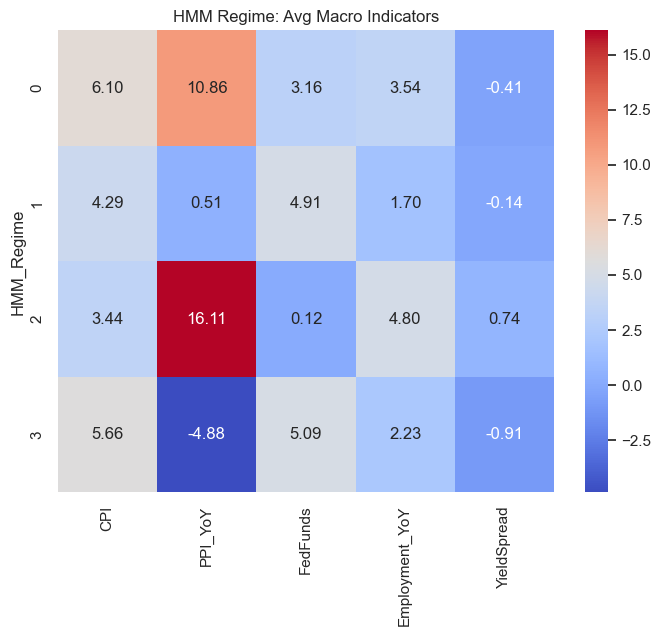

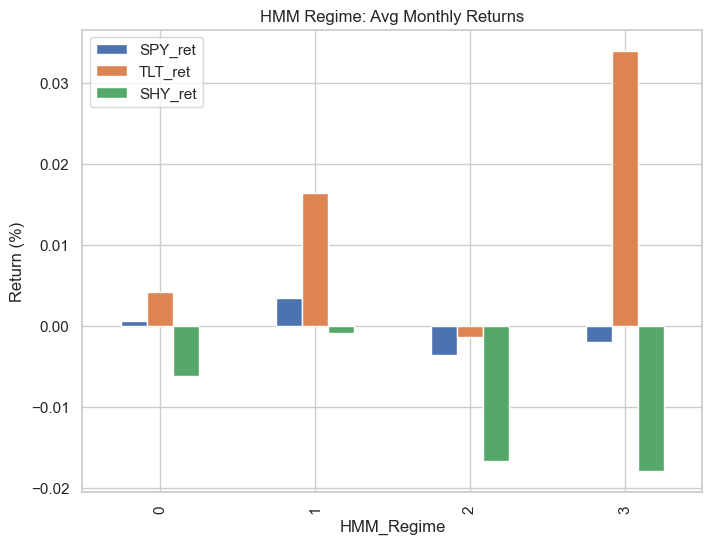

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# Average macro indicators by regime
hmm_macro_means = combined.groupby('HMM_Regime')[['CPI', 'PPI_YoY', 'FedFunds', 'Employment_YoY', 'YieldSpread']].mean()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(hmm_macro_means, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("HMM Regime: Avg Macro Indicators")
plt.show()

# Average returns by regime
hmm_return_means = combined.groupby('HMM_Regime')[['SPY_ret', 'TLT_ret', 'SHY_ret']].mean()

# Barplot
hmm_return_means.plot(kind='bar', figsize=(8,6))
plt.title("HMM Regime: Avg Monthly Returns")
plt.ylabel("Return (%)")
plt.grid(True)
plt.show()

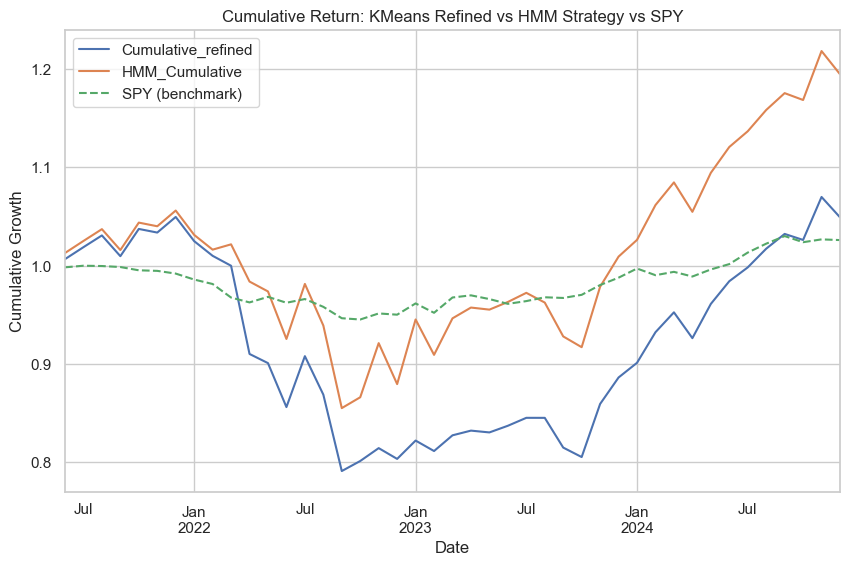

In [84]:
combined['HMM_Strategy_ret'] = combined.apply(
    lambda row: (
        row['SPY_ret'] * refined_weights[row['HMM_Regime']]['SPY_ret'] +
        row['TLT_ret'] * refined_weights[row['HMM_Regime']]['TLT_ret'] +
        row['SHY_ret'] * refined_weights[row['HMM_Regime']]['SHY_ret']
    ), axis=1
)

combined['HMM_Cumulative'] = (1 + combined['HMM_Strategy_ret']).cumprod()

# Plot
combined[['Cumulative_refined', 'HMM_Cumulative']].plot(figsize=(10,6))
(1 + combined['SPY_ret']).cumprod().plot(style='--', label='SPY (benchmark)')
plt.title("Cumulative Return: KMeans Refined vs HMM Strategy vs SPY")
plt.ylabel("Cumulative Growth")
plt.legend()
plt.grid(True)
plt.show()

In [85]:
cagr_hmm = compute_cagr(combined['HMM_Cumulative'])
mdd_hmm = compute_max_drawdown(combined['HMM_Cumulative'])
sharpe_hmm = (combined['HMM_Strategy_ret'].mean() / combined['HMM_Strategy_ret'].std()) * np.sqrt(12)

print(f"HMM Strategy - CAGR: {cagr_hmm:.2%}")
print(f"HMM Strategy - Max Drawdown: {mdd_hmm:.2%}")
print(f"HMM Strategy - Sharpe Ratio: {sharpe_hmm:.2f}")

HMM Strategy - CAGR: 4.82%
HMM Strategy - Max Drawdown: -19.02%
HMM Strategy - Sharpe Ratio: 0.48


/var/folders/8f/8x77b8nd28388ydp8lljv7c80000gn/T/ipykernel_34867/120090985.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (series[-1] / series[0])**(1 / n_years) - 1


/var/folders/8f/8x77b8nd28388ydp8lljv7c80000gn/T/ipykernel_34867/1802515308.py:15: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/parthasarathichakraborty/Downloads/project/macro_factor_timing/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/parthasarathichakraborty/Downloads/project/macro_factor_timing/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


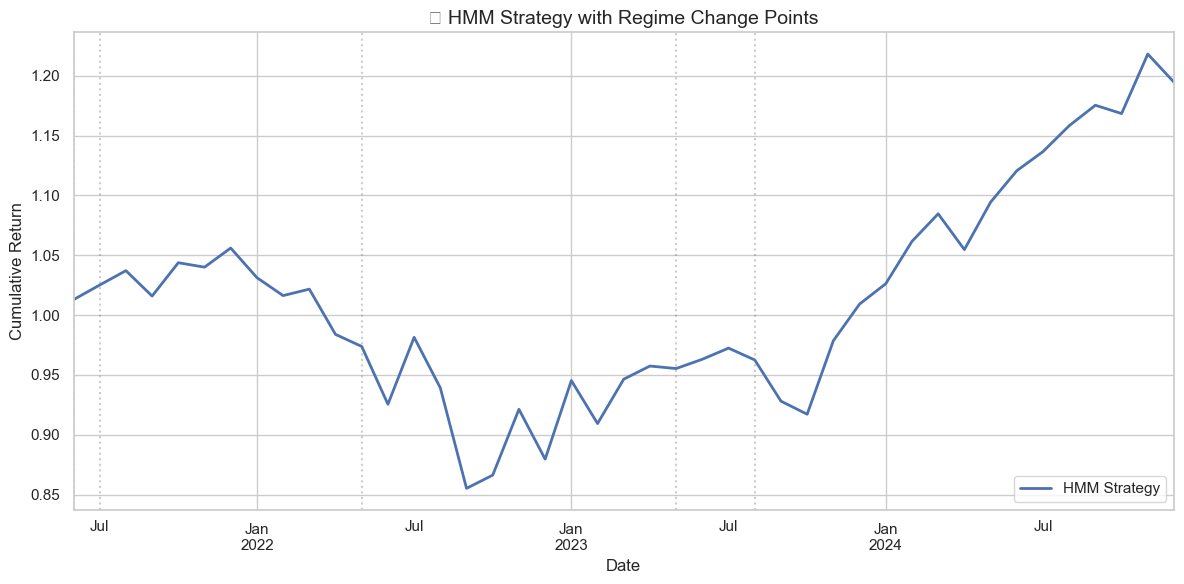

In [86]:
# Optional: highlight HMM regime periods
fig, ax = plt.subplots(figsize=(12, 6))
combined['HMM_Cumulative'].plot(ax=ax, label='HMM Strategy', linewidth=2)

# Shade regime zones
current_regime = None
for date, regime in combined['HMM_Regime'].items():
    if regime != current_regime:
        current_regime = regime
        ax.axvline(x=date, color='gray', linestyle=':', alpha=0.4)

ax.set_title("📊 HMM Strategy with Regime Change Points", fontsize=14)
ax.set_ylabel("Cumulative Return")
ax.legend()
plt.tight_layout()
plt.show()

## Annotated Cumulative Return Chart (HMM vs Refined vs SPY) [Optional]

/var/folders/8f/8x77b8nd28388ydp8lljv7c80000gn/T/ipykernel_34867/3606595449.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/parthasarathichakraborty/Downloads/project/macro_factor_timing/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/parthasarathichakraborty/Downloads/project/macro_factor_timing/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


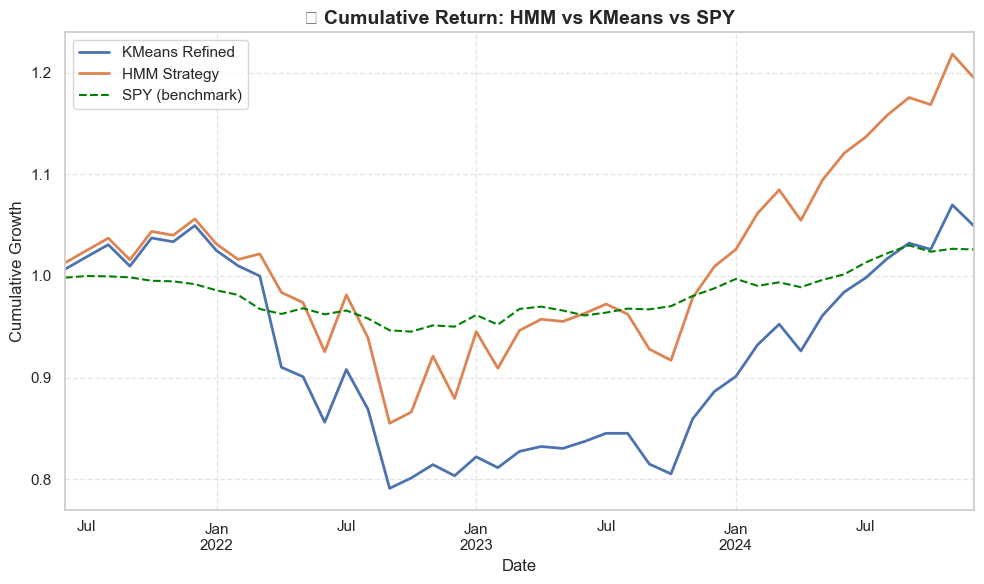

In [87]:
fig, ax = plt.subplots(figsize=(10, 6))
combined['Cumulative_refined'].plot(ax=ax, label='KMeans Refined', linewidth=2)
combined['HMM_Cumulative'].plot(ax=ax, label='HMM Strategy', linewidth=2)
(1 + combined['SPY_ret']).cumprod().plot(ax=ax, label='SPY (benchmark)', linestyle='--', color='green')

# Titles & annotations
ax.set_title("📈 Cumulative Return: HMM vs KMeans vs SPY", fontsize=14, weight='bold')
ax.set_ylabel("Cumulative Growth")
ax.set_xlabel("Date")
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()